In [1]:
import os
import shutil
import sys
import random
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical, Sequence

import tensorflow as tf
import cv2

Using TensorFlow backend.


In [2]:
np.set_printoptions(threshold=sys.maxsize)
img_height, img_width = 256,256

In [3]:
base_path = 'D:/Image Segmentation'
data_folder = os.path.join( base_path, 'Dataset')

train_imgs_folder = os.path.join( data_folder, 'train' )
train_masks_folder = os.path.join( data_folder, 'train_masks' )
val_imgs_folder = os.path.join( data_folder, 'val' )
val_masks_folder = os.path.join( data_folder, 'val_masks')

## Data Preprocessing

In [4]:
train_images_path = []
train_masks_path = []
val_images_path = []
val_masks_path = []
for item in os.listdir(train_imgs_folder+'/train'):
    train_images_path.append(train_imgs_folder+'/train/'+item)
for item in os.listdir(train_masks_folder+'/train_masks'):
    train_masks_path.append(train_masks_folder+'/train_masks/'+item)
for item in os.listdir(val_imgs_folder+'/val'):
    val_images_path.append(val_imgs_folder+'/val/'+item)
for item in os.listdir(val_masks_folder+'/val_masks'):
    val_masks_path.append(val_masks_folder+'/val_masks/'+item)
trainpair = list(zip(train_images_path,train_masks_path))
valpair = list(zip(val_images_path,val_masks_path))

In [5]:
class_map = {
(64, 128, 64):0, #Animal
(192, 0, 128):1, #Archway
(0, 128, 192):2, #Bicyclist
(0, 128, 64):3, #Bridge
(128, 0, 0):4, #Building
(64, 0, 128):5, #Car
(64, 0, 192):6, #CartLuggagePram
(192, 128, 64):7, #Child
(192, 192, 128):8, #Column_Pole
(64, 64, 128):9, #Fence
(128, 0, 192):10, #LaneMkgsDriv
(192, 0, 64):11, #LaneMkgsNonDriv
(128, 128, 64):12, #Misc_Text
(192, 0, 192):13, #MotorcycleScooter
(128, 64, 64):14, #OtherMoving
(64, 192, 128):15, #ParkingBlock
(64, 64, 0):16, #Pedestrian
(128, 64, 128):17, #Road
(128, 128, 192):18, #RoadShoulder
(0, 0, 192):19, #Sidewalk
(192, 128, 128):20, #SignSymbol
(128, 128, 128):21, #Sky
(64, 128, 192):22, #SUVPickupTruck
(0, 0, 64):23, #TrafficCone
(0, 64, 64):24, #TrafficLight
(192, 64, 128):25, #Train
(128, 128, 0):26, #Tree
(192, 128, 192):27, #Truck_Bus
(64, 0, 64):28, #Tunnel
(192, 192, 0):29, #VegetationMisc
(0, 0, 0):30, #Void
(64, 192, 0):31 #Wall
}

colour_map = {
0:(64, 128, 64), #Animal
1:(192, 0, 128), #Archway
2:(0, 128, 192), #Bicyclist
3:(0, 128, 64), #Bridge
4:(128, 0, 0), #Building
5:(64, 0, 128), #Car
6:(64, 0, 192), #CartLuggagePram
7:(192, 128, 64), #Child
8:(192, 192, 128), #Column_Pole
9:(64, 64, 128), #Fence
10:(128, 0, 192), #LaneMkgsDriv
11:(192, 0, 64), #LaneMkgsNonDriv
12:(128, 128, 64), #Misc_Text
13:(192, 0, 192), #MotorcycleScooter
14:(128, 64, 64), #OtherMoving
15:(64, 192, 128), #ParkingBlock
16:(64, 64, 0), #Pedestrian
17:(128, 64, 128), #Road
18:(128, 128, 192), #RoadShoulder
19:(0, 0, 192), #Sidewalk
20:(192, 128, 128), #SignSymbol
21:(128, 128, 128), #Sky
22:(64, 128, 192), #SUVPickupTruck
23:(0, 0, 64), #TrafficCone
24:(0, 64, 64), #TrafficLight
25:(192, 64, 128), #Train
26:(128, 128, 0), #Tree
27:(192, 128, 192), #Truck_Bus
28:(64, 0, 64), #Tunnel
29:(192, 192, 0), #VegetationMisc
30:(0, 0, 0), #Void
31:(64, 192, 0) #Wall
}

In [6]:
class DataGenerator(Sequence):
    
    def __init__(self, pair, class_map, batch_size, dim=(img_height,img_width,3), shuffle=True):
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.pair) / self.batch_size))

    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [k for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self): 
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):

        batch_imgs = []
        batch_masks = []

        for i in list_IDs_temp:
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            
            masks = np.zeros([self.dim[0],self.dim[1]],dtype=int)
            masksarray = load_img(self.pair[i][1],target_size=self.dim)
            masksarray = img_to_array(masksarray)
            
            for height in range(self.dim[0]):
                for width in range(self.dim[1]):
                    colour = (masksarray[height][width][0],masksarray[height][width][1],masksarray[height][width][2])
                    try:
                        masks[height][width] = class_map[colour]
                    except:
                        masks[height][width] = 0

            masks = to_categorical(masks , num_classes = 32)
            batch_masks.append(masks)
            
        return np.array(batch_imgs) ,np.array(batch_masks)

In [7]:
train_generator = DataGenerator(trainpair,class_map,batch_size=8, dim=(img_height,img_width,3) ,shuffle=True)
train_steps = train_generator.__len__()

val_generator = DataGenerator(valpair,class_map,batch_size=8, dim=(img_height,img_width,3),shuffle=True)
val_steps = val_generator.__len__()

## Creating a U-Net model

In [8]:
def unet():
    inputs = Input((img_height, img_width, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(32, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    
    
    return model

In [9]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [10]:
model.compile(optimizer=Adam(lr=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

## Setting up callbacks

In [ ]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('segmentation.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
]

## Training

In [12]:
results = model.fit_generator(train_generator, epochs=100, 
                          steps_per_epoch = train_steps,
                          validation_data=val_generator, 
                          validation_steps=val_steps, 
                          callbacks=callbacks
                             )

Epoch 1/100
8/8 [==============================] - 53s 7s/step - loss: 3.3096 - accuracy: 0.1127 - val_loss: 2.9983 - val_accuracy: 0.1842

Epoch 00001: val_accuracy improved from -inf to 0.18422, saving model to segmentation.h5
Epoch 2/100
8/8 [==============================] - 47s 6s/step - loss: 2.8074 - accuracy: 0.2183 - val_loss: 2.6128 - val_accuracy: 0.2141

Epoch 00002: val_accuracy improved from 0.18422 to 0.21415, saving model to segmentation.h5
Epoch 3/100
8/8 [==============================] - 46s 6s/step - loss: 2.5350 - accuracy: 0.2824 - val_loss: 2.3869 - val_accuracy: 0.1905

Epoch 00003: val_accuracy did not improve from 0.21415
Epoch 4/100
8/8 [==============================] - 48s 6s/step - loss: 2.3312 - accuracy: 0.2931 - val_loss: 2.2352 - val_accuracy: 0.2431

Epoch 00004: val_accuracy improved from 0.21415 to 0.24315, saving model to segmentation.h5
Epoch 5/100
8/8 [==============================] - 52s 6s/step - loss: 2.0765 - accuracy: 0.3334 - val_loss: 2.0

C:\Users\Ong\Desktop\Programming\Anaconda3\envs\ML\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.380887). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


2/8 [======>.......................] - ETA: 40s - loss: 1.8621 - accuracy: 0.4366

C:\Users\Ong\Desktop\Programming\Anaconda3\envs\ML\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.321402). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


8/8 [==============================] - 46s 6s/step - loss: 1.7805 - accuracy: 0.4312 - val_loss: 1.7025 - val_accuracy: 0.5049

Epoch 00006: val_accuracy improved from 0.46460 to 0.50487, saving model to segmentation.h5
Epoch 7/100
1/8 [==>...........................] - ETA: 39s - loss: 1.6462 - accuracy: 0.5218

C:\Users\Ong\Desktop\Programming\Anaconda3\envs\ML\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.336891). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


8/8 [==============================] - 46s 6s/step - loss: 1.5693 - accuracy: 0.5360 - val_loss: 1.4081 - val_accuracy: 0.6068

Epoch 00007: val_accuracy improved from 0.50487 to 0.60678, saving model to segmentation.h5
Epoch 8/100
8/8 [==============================] - 45s 6s/step - loss: 1.3675 - accuracy: 0.6023 - val_loss: 1.3329 - val_accuracy: 0.6841

Epoch 00008: val_accuracy improved from 0.60678 to 0.68413, saving model to segmentation.h5
Epoch 9/100
8/8 [==============================] - 45s 6s/step - loss: 1.1952 - accuracy: 0.6848 - val_loss: 1.2519 - val_accuracy: 0.6836

Epoch 00009: val_accuracy did not improve from 0.68413
Epoch 10/100
8/8 [==============================] - 47s 6s/step - loss: 1.3291 - accuracy: 0.6159 - val_loss: 1.2370 - val_accuracy: 0.6565

Epoch 00010: val_accuracy did not improve from 0.68413
Epoch 11/100
8/8 [==============================] - 48s 6s/step - loss: 1.2414 - accuracy: 0.6542 - val_loss: 1.3210 - val_accuracy: 0.6547

Epoch 00011: val


KeyboardInterrupt



In [13]:
model.load_weights('segmentation.h5')

In [14]:
pair = valpair[0]
img = img_to_array(load_img(pair[0] , target_size=(img_height,img_width)))
gt_mask = img_to_array(load_img(pair[1] , target_size=(img_height,img_width)))

In [15]:
def predict(model,img_path,shape):
    img = img_to_array(load_img(img_path,target_size=shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [16]:
pred_label = predict(model, pair[0], (img_height,img_width,3))

In [17]:
pred_mask = np.zeros([img_width,img_height,3],dtype=int)
for height in range(pred_mask.shape[0]):
    for width in range(pred_mask.shape[1]):
        class_label = pred_label[height][width]
        pred_mask[height][width][0] = colour_map[class_label][0]
        pred_mask[height][width][1] = colour_map[class_label][1]
        pred_mask[height][width][2] = colour_map[class_label][2]

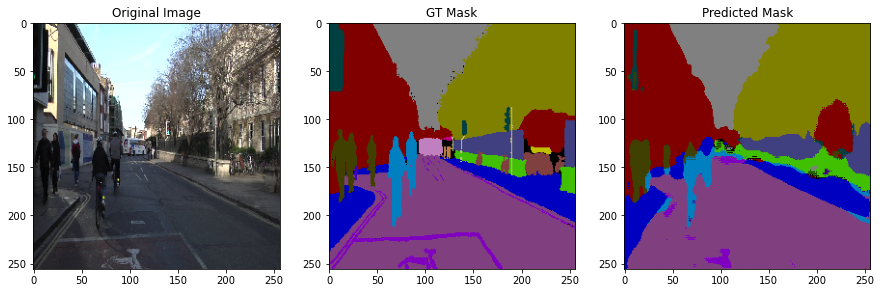

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('GT Mask')
plt.imshow(gt_mask/255.)
plt.subplot(133)
plt.imshow(pred_mask/255.);plt.title('Predicted Mask')
plt.show()